<div align="center">

# YOLOv3 image simple object detection
</div>

YOLOv3 (You Only Look Once v3) is a state-of-the-art object detection algorithm that is widely used in computer vision applications. It is known for its fast inference speed and high accuracy in detecting multiple objects in an image. In this Jupyter notebook, we will implement a YOLOv3 object detection algorithm on a set of test images using Python and OpenCV library. We will use pre-trained weights and configurations for YOLOv3 and YOLOv3-tiny models to detect objects in images and draw bounding boxes around them with corresponding labels.


## Downloading pretrained models and test images

In [1]:
!git clone https://github.com/pjreddie/darknet

Cloning into 'darknet'...
remote: Enumerating objects: 5955, done.
remote: Total 5955 (delta 0), reused 0 (delta 0), pack-reused 5955
Receiving objects: 100% (5955/5955), 6.37 MiB | 20.65 MiB/s, done.
Resolving deltas: 100% (3931/3931), done.


In [2]:
!git clone https://github.com/mohamedamine99/YOLOv3-simple-object-detection

Cloning into 'YOLOv3-simple-object-detection'...
remote: Enumerating objects: 49, done.
remote: Counting objects: 100% (49/49), done.
remote: Compressing objects: 100% (41/41), done.
remote: Total 49 (delta 9), reused 46 (delta 6), pack-reused 0
Unpacking objects: 100% (49/49), 19.97 MiB | 8.46 MiB/s, done.


In [3]:
!wget https://pjreddie.com/media/files/yolov3-tiny.weights

--2023-03-11 13:57:31--  https://pjreddie.com/media/files/yolov3-tiny.weights
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 35434956 (34M) [application/octet-stream]
Saving to: ‘yolov3-tiny.weights’

yolov3-tiny.weights 100%[===================>]  33.79M  26.5MB/s    in 1.3s    

2023-03-11 13:57:33 (26.5 MB/s) - ‘yolov3-tiny.weights’ saved [35434956/35434956]



In [4]:
!wget https://pjreddie.com/media/files/yolov3.weights

--2023-03-11 13:57:33--  https://pjreddie.com/media/files/yolov3.weights
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248007048 (237M) [application/octet-stream]
Saving to: ‘yolov3.weights’

yolov3.weights      100%[===================>] 236.52M  39.8MB/s    in 6.2s    

2023-03-11 13:57:40 (38.3 MB/s) - ‘yolov3.weights’ saved [248007048/248007048]



## YOLOv3 implementation

In [5]:
import os
import shutil

import numpy as np
import cv2
import matplotlib.pyplot as plt


In [6]:
# Paths for various files and directories
coco_names_file = '/content/YOLOv3-simple-object-detection/coco.names'

yolov3_cfg = '/content/YOLOv3-simple-object-detection/configs/yolov3.cfg'
yolov3_tiny_cfg = '/content/YOLOv3-simple-object-detection/configs/yolov3-tiny.cfg'

yolov3_weights = '/content/yolov3.weights'
yolov3_tiny_weights = '/content/yolov3-tiny.weights'

test_imgs_path = '/content/YOLOv3-simple-object-detection/test imgs'
results_yolov3 = '/content/results/YOLOv3'
results_yolov3_tiny = '/content/results/YOLOv3_tiny'

In [7]:
# Reading the COCO dataset class names from the coco names file
labels = []
with open(coco_names_file, 'rt') as coco_file:
    labels = coco_file.read().rstrip('\n').rsplit('\n')
    
print(labels)

['person', 'bicycle', 'car', 'motorbike', 'aeroplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'sofa', 'pottedplant', 'bed', 'diningtable', 'toilet', 'tvmonitor', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']


In [8]:
# Creating YOLOv3 DNN model from configuration and pre-trained weights
net = cv2.dnn.readNetFromDarknet(yolov3_cfg, yolov3_weights)

# Creating YOLOv3-tiny DNN model from configuration and pre-trained weights
net_tiny = cv2.dnn.readNetFromDarknet(yolov3_tiny_cfg, yolov3_tiny_weights)

In [9]:
def preprocess_img_for_detection(net, img, size = (320, 320)):
    """
    This function preprocesses an input image for object detection using a specified YOLOv3 or YOLOv3-tiny
    DNN model. The image is resized to the specified size and converted into a blob. The blob is then set
    as the input for the DNN model. The function returns the output of the DNN model after forward pass.

    Parameters:
        net: cv2.dnn_Net object
        YOLOv3 or YOLOv3-tiny DNN model.

        img: numpy.ndarray
        Input image for object detection.
    
        size: tuple, optional
        Size to which the input image is resized. Default value is (320, 320).

    Returns:
        outputs: numpy.ndarray
        Output of the DNN model after forward pass.
    

    """
    # Convert the input image into a blob
    blob = cv2.dnn.blobFromImage(img, 1 / 255, size , [0, 0, 0], 1, crop=False)

    # Set the blob as the input for the DNN model
    net.setInput(blob)
    layersNames = net.getLayerNames()

    # Perform forward pass through the DNN model
    output_layers_idx = net.getUnconnectedOutLayers()[0]-1
    outputNames = [(layersNames[idx-1]) for idx in  net.getUnconnectedOutLayers()]
    #print(outputNames)
    outputs = net.forward(outputNames)

    # Return the output of the DNN model after forward pass
    return outputs


In [10]:
def detectObjects(img, outputs, score_threshold = 0.8, NMS_threshold = 0.5 ):
    """
    This function takes an input image and the output of a YOLOv3 or YOLOv3-tiny DNN model after forward pass,
    detects objects in the image and draws bounding boxes around the objects. It also writes the class label and
    confidence score for each object inside the bounding box.

    Parameters:
        img: numpy.ndarray
        Input image for object detection.

        outputs: numpy.ndarray
        Output of the YOLOv3 or YOLOv3-tiny DNN model after forward pass.
            
        score_threshold: float, optional
            Minimum confidence score required for an object to be considered for detection. Default value is 0.8.
            
        NMS_threshold: float, optional
            Non-maximum suppression threshold for eliminating overlapping bounding boxes. Default value is 0.5.
    
        Returns:
            img: numpy.ndarray
            Input image with bounding boxes and class labels drawn around the detected objects.
    
    """
    # Get the shape of the input image
    hT, wT, cT = img.shape

    # Create empty lists to store the bounding boxes, class IDs and confidence scores for detected objects
    bbox = []
    classIds = []
    confs = []

    # Loop over each output of the DNN model after forward pass
    for output in outputs:
        # Loop over each detection in the output
        for det in output:
        # Extract the class ID, confidence score and bounding box coordinates from the detection
            scores = det[5:]
            classId = np.argmax(scores)
            confidence = scores[classId]
            if confidence > score_threshold:
                w,h = int(det[2]*wT) , int(det[3]*hT)
                x,y = int((det[0]*wT)-w/2) , int((det[1]*hT)-h/2)
                bbox.append([x,y,w,h])
                classIds.append(classId)
                confs.append(float(confidence))

    # Perform non-maximum suppression to eliminate overlapping bounding boxes
    indices = cv2.dnn.NMSBoxes(bbox, confs, score_threshold, NMS_threshold)

    # Loop over each index in the indices list
    for i in indices :
        # Get the bounding box coordinates, class label and confidence score for the current index
        box = bbox[i]
        x, y, w, h = box[0], box[1], box[2], box[3]
        cv2.rectangle(img, (x, y), (x+w,y+h), (255, 0 , 255), 2)
        cv2.putText(img,f'{labels[classIds[i]].upper()} {int(confs[i]*100)}%',
                    (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0, 255), 2)
        
    #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Return the input image with bounding boxes and class labels drawn around the detected objects
    return img

 

In [11]:
img = cv2.imread('/content/YOLOv3-simple-object-detection/test imgs/highway.PNG')


In [12]:
outputs = preprocess_img_for_detection(net = net , img = img, size = (320, 320))
img = detectObjects(img, outputs, score_threshold = 0.7, NMS_threshold = 0.4 )

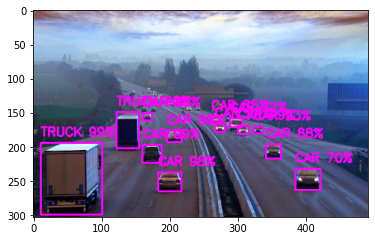

In [13]:
plt.imshow(img)

In [14]:
# Creating directories to store resulting images
os.makedirs(results_yolov3) 
os.makedirs(results_yolov3_tiny) 

In [15]:
# Perform object detection with yolov3 on our test images and save the results
for img_file in os.listdir(test_imgs_path):
    img = cv2.imread(os.path.join(test_imgs_path, img_file))
    outputs = preprocess_img_for_detection(net = net , img = img, size = (320, 320))
    img = detectObjects(img, outputs, score_threshold = 0.7, NMS_threshold = 0.4 )
    cv2.imwrite(os.path.join(results_yolov3, img_file), img)


In [16]:
# Perform object detection with yolov3_tiny on our test images and save the results
for img_file in os.listdir(test_imgs_path):
    img = cv2.imread(os.path.join(test_imgs_path, img_file))
    outputs = preprocess_img_for_detection(net = net_tiny , img = img, size = (320, 320))
    img = detectObjects(img, outputs, score_threshold = 0.5, NMS_threshold = 0.2 )
    cv2.imwrite(os.path.join(results_yolov3_tiny, img_file), img)

In [17]:
!zip -r results.zip /content/results

  adding: content/results/ (stored 0%)
  adding: content/results/YOLOv3/ (stored 0%)
  adding: content/results/YOLOv3/street 2.PNG (deflated 1%)
  adding: content/results/YOLOv3/highway.PNG (deflated 0%)
  adding: content/results/YOLOv3/people crossing the street.jpg (deflated 0%)
  adding: content/results/YOLOv3/2 dogs.PNG (deflated 1%)
  adding: content/results/YOLOv3/nyc street.PNG (deflated 0%)
  adding: content/results/YOLOv3/2 cats.PNG (deflated 1%)
  adding: content/results/YOLOv3_tiny/ (stored 0%)
  adding: content/results/YOLOv3_tiny/street 2.PNG (deflated 1%)
  adding: content/results/YOLOv3_tiny/highway.PNG (deflated 0%)
  adding: content/results/YOLOv3_tiny/people crossing the street.jpg (deflated 0%)
  adding: content/results/YOLOv3_tiny/2 dogs.PNG (deflated 1%)
  adding: content/results/YOLOv3_tiny/nyc street.PNG (deflated 0%)
  adding: content/results/YOLOv3_tiny/2 cats.PNG (deflated 1%)
